**А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана**

*Экспортируем нужные библиотеки, смотрим данные, проверяем, чтобы не было пустых значений*

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [11]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [10]:
df.isnull().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

*Разбиваем данные на тестовую и контрольную выборки и, используя функцию по подсчету метрики качества FPR, рассчитываем p-значение и сравниваем его с границей 0,05*

In [3]:
df_0 = df.query('experimentVariant == 0').purchase
df_1 = df.query('experimentVariant == 1').purchase

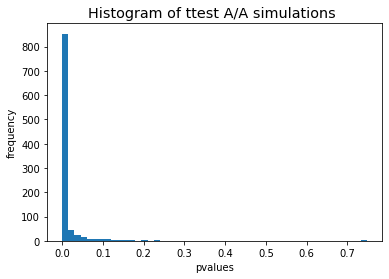

0.929

In [4]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_0.sample(n_s, replace = False).values
    s2 = df_1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

*Как мы видим, p-значение значительно больше 0,05, соответственно, выборки разбиты некорректно. Попробуем отыскать аномалию в данных. Ввиду того, что в исходных данных кроме id, номера выборки и колонки "покупка" есть только столбец "номер версии приложения", ничего не остается как искать в нем*

*Проведем соответствующую группировку данных по выборке и версии приложения*

In [7]:
df.groupby(['experimentVariant', 'version'], as_index = False).agg({'purchase':'sum'})

,experimentVariant,version,purchase
0,0,v2.8.0,41
1,0,v2.9.0,890
2,0,v3.7.4.0,252
3,0,v3.8.0.0,328
4,1,v2.8.0,1895
5,1,v2.9.0,858
6,1,v3.7.4.0,266
7,1,v3.8.0.0,384


*Как мы видим, в выборке 0, приложения "v2.8.0" число покупок 46 раз меньше, чем в выборке 1. В других приложениях такого не наблюдается и число покупок приблизительно равнозначное.*

*Похоже на то, что аномалия наблюдается в данных с версией приложения "v2.8.0". Попробуем исключить данную версию из выборок и проверить p-значение по функции метрики FRP*

In [8]:
df_0_upd = df.query('experimentVariant == 0 and version != "v2.8.0"').purchase
df_1_upd = df.query('experimentVariant == 1 and version != "v2.8.0"').purchase

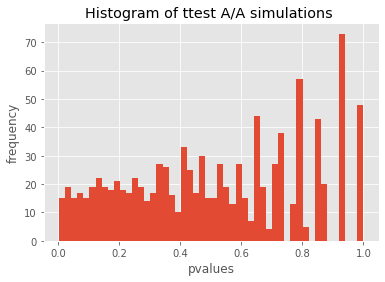

0.041

In [9]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_0_upd.sample(n_s, replace = False).values
    s2 = df_1_upd.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

**Как мы видим, p-значение меньше 0,05, соответственно, выборки теперь разбиты корректно. Делаем вывод, что поломка сплит-системы связана с данными по приложению "v2.8.0".**

*P.S. Однако, стоит отметить, что, исключив данные по выборке "v2.8.0" мы потеряли больше половины данных, что однозначно в дальнейшем плохо скажется на статисических тестах и наших выводах. Соответственно, предлагается в дальнейшем запросить дополнительную информацию по клиентам для поиска более детальных аноматий и сохранения основного массива данных.*